# TP2 Álgebra Lineal Computacional

## Procesamiento de datos

1. Cargo el archivo "Tabla nutricional", lleno los datos nulos con 0 y modifico los valores para que todos estén en la misma unidad de medida (gr)

In [2]:
#Leo el archivo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("tabla_nutricional.csv", encoding='latin_1',delimiter=';')

consumidores_libres = pd.read_csv("consumidores_libres.csv", encoding='latin_1',delimiter=';')

In [3]:
#Completo con ceros
tn = df.fillna(0)

#Cambio todas las unidades de medida a gr
nuevosNombres = {}
for col in tn.columns:
    if "mg" in col:
        tn[col] = tn[col]/1000
    nuevosNombres[col] = col.replace('mg','gr')
tn = tn.rename(columns=nuevosNombres)

## Consigna 2 - Definimos la función cumpleMargen

In [4]:
def cumpleMargen(data):
    proteinas = data[data.columns[3]].sum()
    grasas = data[data.columns[4]].sum()
    carbohidratos = data[data.columns[2]].sum()
    sodio = data[data.columns[5]].sum()
    fibras = data[data.columns[12]].sum()

    total = proteinas + grasas + carbohidratos + sodio + fibras

    frutasYverduras = data.loc[data['Alimento'].isin(["Acelga","Zanahoria","Tomate","Lechuga","Cebolla","Zapallo","Manzana","Naranja","Mandarina","pera","Banana","Papa","Batata","Tomate envasado"])]
    frutVer = frutasYverduras[frutasYverduras.columns[1]].sum()

    
    res = True
    if (grasas < total * 0.15) or (grasas > total * 0.30):
        res = False
    elif (carbohidratos < total * 0.55) or (carbohidratos > total * 0.75):
        res = False
    elif(proteinas < total * 0.10) or (proteinas > total * 0.15):
        res = False
    elif (sodio < 200):
        res = False
    elif (fibras < 25):
        res = False
    elif (frutVer < 400):
        res = False
    return res

print("Cumple margen (tabla nutricional):",cumpleMargen(tn))

Cumple margen (tabla nutricional): False


Podemos observar que nuestra tabla nutricional no cumple el margen de ingesta nutricional de la OMS

## Consigna 3 - Realizamos un ACP con los datos de la tabla nutricional

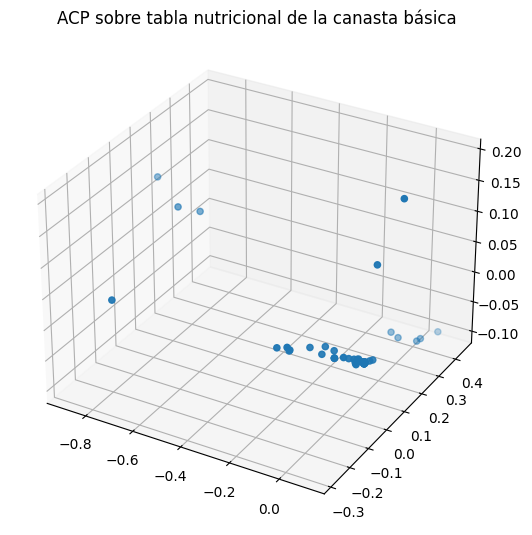

In [5]:
# Modifico la tabla nutricional para que me muestre los nutrientes de cada alimento por gramo.

cantidades = tn[tn.columns[1]]
tn0 = tn.copy()
for i in range(tn.shape[0]):
    tn0.iloc[i,1:] = tn0.iloc[i,1:]/cantidades[i]

# Consigo las medias por columna, esto es la media de cada nutriente.

tnMedias = np.mean(tn0.iloc[:,2:], axis=0)

# Resto a cada columna la media, esto me deja una matriz centrada.

tnCentrado = tn0.iloc[:,2:]

for i in range(tnCentrado.shape[1]):
    tnCentrado[tnCentrado.columns[i]] = tnCentrado[tnCentrado.columns[i]] - tnMedias[i]

# Defino la matriz de covarianza

tnCovarianza = (tnCentrado.T @ tnCentrado)*(1/(tnCentrado.shape[0]-1))

# Busco los 3 autovectores de mayor autovalor de la matriz de covarianza

eigh = np.linalg.eigh(tnCovarianza)

avecs = eigh[1][::-1][0:3]

# Consigo las proyecciones de cada alimento

tnProyecciones = np.dot(tnCentrado,avecs.T)

# Grafico las proyecciones.

fig = plt.figure(figsize=(14,28))
ax = fig.add_subplot(121,projection='3d')
ax.scatter(tnProyecciones[:,0],tnProyecciones[:,1],tnProyecciones[:,2])
ax.set_title("ACP sobre tabla nutricional de la canasta básica")
plt.show()


Podemos observar que en el gráfico tenemos a la mayoría de los alimentos agrupados bastante próximos entre sí, sin embargo se aprecia que varios alimentos quedan separados.

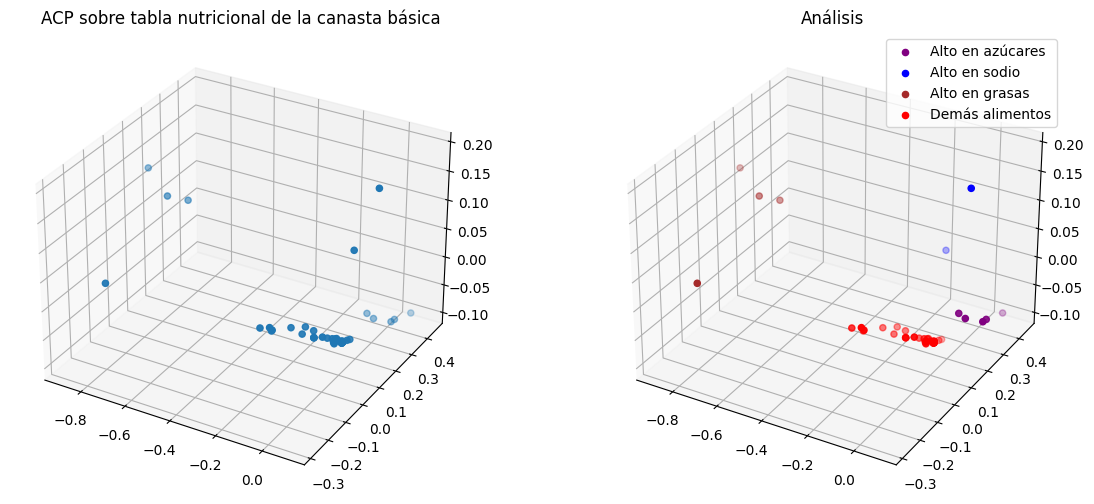

In [6]:
# Análisis de los clusters

# Separo la tabla nutricional según si son altos en azúcares, sodio o grasas.

Azucarados = tn0[tn0["Azucares Libres (gr)"]>0.5]["Alimento"]
Grasos = tn0[tn0["Grasas (gr)"]>0.7]["Alimento"]
Sodio = tn0[tn0["Na (gr)"]>0.2]["Alimento"]

tnAzucarados = tn0.loc[tn0['Alimento'].isin(Azucarados)]
tnGrasos = tn0.loc[tn0['Alimento'].isin(Grasos)]
tnSodio = tn0.loc[tn0['Alimento'].isin(Sodio)]

tnResto = tn0.loc[~tn0['Alimento'].isin(Azucarados)]
tnResto = tnResto.loc[~tn0['Alimento'].isin(Sodio)]
tnResto = tnResto.loc[~tn0['Alimento'].isin(Grasos)]


# Centro todas las tablas

tnRestoCentrado = tnResto.iloc[:,2:]
for i in range(tnRestoCentrado.shape[1]):
    tnRestoCentrado[tnRestoCentrado.columns[i]] = tnRestoCentrado[tnRestoCentrado.columns[i]] - tnMedias[i]

tnGrasosCentrado = tnGrasos.iloc[:,2:]
for i in range(tnGrasosCentrado.shape[1]):
    tnGrasosCentrado[tnGrasosCentrado.columns[i]] = tnGrasosCentrado[tnGrasosCentrado.columns[i]] - tnMedias[i]

tnAzucaradosCentrado = tnAzucarados.iloc[:,2:]
for i in range(tnAzucaradosCentrado.shape[1]):
    tnAzucaradosCentrado[tnAzucaradosCentrado.columns[i]] = tnAzucaradosCentrado[tnAzucaradosCentrado.columns[i]] - tnMedias[i]

tnSodioCentrado = tnSodio.iloc[:,2:]
for i in range(tnSodioCentrado.shape[1]):
    tnSodioCentrado[tnSodioCentrado.columns[i]] = tnSodioCentrado[tnSodioCentrado.columns[i]] - tnMedias[i]

# Busco las proyecciones de cada tabla en el espacio de generadores del ACP

tnAzucaradosProyecciones = np.dot(tnAzucaradosCentrado,avecs.T)
tnSodioProyecciones = np.dot(tnSodioCentrado,avecs.T)
tnProyeccionesGrasos = np.dot(tnGrasosCentrado,avecs.T)
tnProyeccionesResto = np.dot(tnRestoCentrado,avecs.T)

# Grafico las proyecciones, diferencio por color cada tipo de alimento.

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(14, 6))

ax1.scatter(tnProyecciones[:,0],tnProyecciones[:,1],tnProyecciones[:,2])
ax1.set_title("ACP sobre tabla nutricional de la canasta básica")

ax2.scatter(tnAzucaradosProyecciones[:,0],tnAzucaradosProyecciones[:,1],tnAzucaradosProyecciones[:,2],color="purple", label = "Alto en azúcares")
ax2.scatter(tnSodioProyecciones[:,0],tnSodioProyecciones[:,1],tnSodioProyecciones[:,2],color="blue", label = "Alto en sodio")
ax2.scatter(tnProyeccionesGrasos[:,0],tnProyeccionesGrasos[:,1],tnProyeccionesGrasos[:,2], color = "brown", label = "Alto en grasas")
ax2.scatter(tnProyeccionesResto[:,0],tnProyeccionesResto[:,1],tnProyeccionesResto[:,2], color = "red", label = "Demás alimentos")
ax2.set_title("Análisis")
ax2.legend()

plt.show()

Los alimentos que quedaron separados son aquellos que tienen una proporción mucho mayor de grasas (ej: manteca, aceite), sodio (sal, caldo concentrado) o azúcar (ej: galletitas, mermelada) en comparación con los demás, y esta diferencia se refleja como distancia en el espacio de generadores del ACP.

## Consigna 4 - Proyección de los elementos de la tabla Consumidores Libres sobre los generadores del ACP

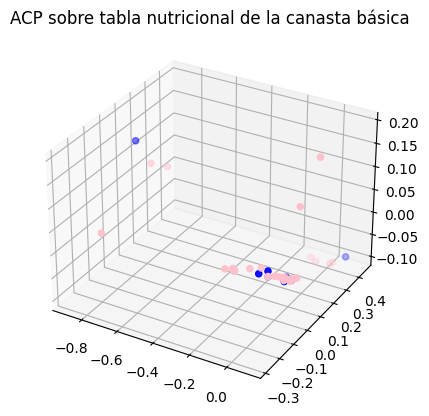

In [7]:
#Elementos de la tabla consumidores_libres

alim_cl = consumidores_libres["PRODUCTOS"].tolist()

#Reemplazo los nombres para que coincidan con los de la tabla nutricional
alim_cl[0] = "Aceite girasol"
alim_cl[1] = "Arroz"
alim_cl[2] = "Azucar"
alim_cl[3] = "Fideos secos"
alim_cl[4] = "Harina trigo"
alim_cl[5] = "Huevo" 
alim_cl[6] = "Pan Frances"
alim_cl[7] = "Leche fluida entera"
alim_cl[8] = "Yerba"
alim_cl[9] = "Zanahoria"
alim_cl[10] = "Berenjena"
alim_cl[11] = "Tomate"
alim_cl[12] = "Cebolla"
alim_cl[13] = "Papa"
alim_cl[14] = "Acelga"
alim_cl[15] = "Naranja"
alim_cl[16] = "Manzana"
alim_cl[17] = "Bola de Lomo"
alim_cl[18] = "Asado"
alim_cl[19] = "Paleta"
alim_cl[20] = "Carne picada"


#DataFrame con los datos nutricionales de los elementos de la tabla consumidores_libres
cl = tn0.loc[tn0['Alimento'].isin(alim_cl)]
tnResto = tn0.loc[~tn0['Alimento'].isin(alim_cl)]

#Matriz del DataFrame
clCentrado = cl.iloc[:,2:]

for i in range(clCentrado.shape[1]):
    clCentrado[clCentrado.columns[i]] = clCentrado[clCentrado.columns[i]] - tnMedias[i]

tnRestoCentrado = tnResto.iloc[:,2:]
for i in range(tnRestoCentrado.shape[1]):
    tnRestoCentrado[tnRestoCentrado.columns[i]] = tnRestoCentrado[tnRestoCentrado.columns[i]] - tnMedias[i]

proyec = np.dot(clCentrado,avecs.T)
tnProyeccionesResto = np.dot(tnRestoCentrado,avecs.T)

#Gráfico
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(tnProyeccionesResto[:,0],tnProyeccionesResto[:,1],tnProyeccionesResto[:,2], color = "pink")
ax.scatter(proyec[:,0],proyec[:,1],proyec[:,2],color = "blue")
ax.set_title("ACP sobre tabla nutricional de la canasta básica")
plt.show()

# Consigna 5 - 

## Obtenemos los promedios del precio de cada nutriente por gramo mediante las comidas


### Precio por gramo de los carbohidratos según la fecha 

In [8]:
consum_libres = consumidores_libres.rename(columns={"PRODUCTOS": "Alimento", "Cantidad": "Cantidad (gr/ml)"})
consum_libres.iloc[:,0] = alim_cl
consum_libres = consum_libres.sort_values(by='Alimento')
consum_libres = consum_libres[consum_libres['Alimento'] != 'Berenjena']  #Eliminamos la berenjena de la tabla pues no está en la tabla nutricional

HC = tn[['Alimento', 'Cantidad (gr/ml)', 'HC (gr)']]
HC = HC.loc[HC['Alimento'].isin(alim_cl)]
HC.insert(3,'31/12/2023', np.zeros(HC.shape[0]))
HC.insert(4,'31/1/2024', np.zeros(HC.shape[0]))
HC.insert(5,'29/2/2024', np.zeros(HC.shape[0]))
HC.insert(6,'31/3/2024', np.zeros(HC.shape[0]))
HC.insert(7,'30/4/2024', np.zeros(HC.shape[0]))

HC = HC.sort_values('Alimento')
for i in range(HC.shape[0]):
    HC.iloc[i,3] = HC.iloc[i,1] * (consum_libres.iloc[i,2] / consum_libres.iloc[i,1])
    HC.iloc[i,4] = HC.iloc[i,1] * (consum_libres.iloc[i,3] / consum_libres.iloc[i,1])
    HC.iloc[i,5] = HC.iloc[i,1] * (consum_libres.iloc[i,4] / consum_libres.iloc[i,1])
    HC.iloc[i,6] = HC.iloc[i,1] * (consum_libres.iloc[i,5] / consum_libres.iloc[i,1])
    HC.iloc[i,7] = HC.iloc[i,1] * (consum_libres.iloc[i,6] / consum_libres.iloc[i,1])


HC = HC[HC['HC (gr)'] != 0]

HC.iloc[:,1:] = HC.iloc[:,1:].div(HC['HC (gr)'], axis=0)

#Lista con todos los precios de gramo de HC para la primera fecha, luego la segunda...
PreciosGramoDeHC = [HC['31/12/2023'].tolist(), HC['31/1/2024'].tolist(), HC['29/2/2024'].tolist(), HC['31/3/2024'].tolist(), HC['30/4/2024'].tolist()]

### Precio por gramo de las proteínas según la fecha 

In [9]:
consum_libres = consumidores_libres.rename(columns={"PRODUCTOS": "Alimento", "Cantidad": "Cantidad (gr/ml)"})
consum_libres.iloc[:,0] = alim_cl
consum_libres = consum_libres.sort_values(by='Alimento')
consum_libres = consum_libres[consum_libres['Alimento'] != 'Berenjena']  #Eliminamos la berenjena de la tabla pues no está en la tabla nutricional

prot = tn[['Alimento', 'Cantidad (gr/ml)', 'Proteinas (gr)']]
prot = prot.loc[prot['Alimento'].isin(alim_cl)]
prot.insert(3,'31/12/2023', np.zeros(prot.shape[0]))
prot.insert(4,'31/1/2024', np.zeros(prot.shape[0]))
prot.insert(5,'29/2/2024', np.zeros(prot.shape[0]))
prot.insert(6,'31/3/2024', np.zeros(prot.shape[0]))
prot.insert(7,'30/4/2024', np.zeros(prot.shape[0]))

prot = prot.sort_values('Alimento')
for i in range(prot.shape[0]):
    prot.iloc[i,3] = prot.iloc[i,1] * (consum_libres.iloc[i,2] / consum_libres.iloc[i,1])
    prot.iloc[i,4] = prot.iloc[i,1] * (consum_libres.iloc[i,3] / consum_libres.iloc[i,1])
    prot.iloc[i,5] = prot.iloc[i,1] * (consum_libres.iloc[i,4] / consum_libres.iloc[i,1])
    prot.iloc[i,6] = prot.iloc[i,1] * (consum_libres.iloc[i,5] / consum_libres.iloc[i,1])
    prot.iloc[i,7] = prot.iloc[i,1] * (consum_libres.iloc[i,6] / consum_libres.iloc[i,1])


prot = prot[prot['Proteinas (gr)'] != 0]

prot.iloc[:,1:] = prot.iloc[:,1:].div(prot['Proteinas (gr)'], axis=0)

#Lista con todos los precios de gramo de proteína para la primera fecha, luego la segunda...
PreciosGramoDeProteina = [prot['31/12/2023'].tolist(), prot['31/1/2024'].tolist(), prot['29/2/2024'].tolist(), prot['31/3/2024'].tolist(), prot['30/4/2024'].tolist()]

### Precio por gramo de las grasas según la fecha 

In [10]:
consum_libres = consumidores_libres.rename(columns={"PRODUCTOS": "Alimento", "Cantidad": "Cantidad (gr/ml)"})
consum_libres.iloc[:,0] = alim_cl
consum_libres = consum_libres.sort_values(by='Alimento')
consum_libres = consum_libres[consum_libres['Alimento'] != 'Berenjena']  #Eliminamos la berenjena de la tabla pues no está en la tabla nutricional

grasas = tn[['Alimento', 'Cantidad (gr/ml)', 'Grasas (gr)']]
grasas = grasas.loc[grasas['Alimento'].isin(alim_cl)]
grasas.insert(3,'31/12/2023', np.zeros(grasas.shape[0]))
grasas.insert(4,'31/1/2024', np.zeros(grasas.shape[0]))
grasas.insert(5,'29/2/2024', np.zeros(grasas.shape[0]))
grasas.insert(6,'31/3/2024', np.zeros(grasas.shape[0]))
grasas.insert(7,'30/4/2024', np.zeros(grasas.shape[0]))

grasas = grasas.sort_values('Alimento')
for i in range(grasas.shape[0]):
    grasas.iloc[i,3] = grasas.iloc[i,1] * (consum_libres.iloc[i,2] / consum_libres.iloc[i,1])
    grasas.iloc[i,4] = grasas.iloc[i,1] * (consum_libres.iloc[i,3] / consum_libres.iloc[i,1])
    grasas.iloc[i,5] = grasas.iloc[i,1] * (consum_libres.iloc[i,4] / consum_libres.iloc[i,1])
    grasas.iloc[i,6] = grasas.iloc[i,1] * (consum_libres.iloc[i,5] / consum_libres.iloc[i,1])
    grasas.iloc[i,7] = grasas.iloc[i,1] * (consum_libres.iloc[i,6] / consum_libres.iloc[i,1])


grasas = grasas[grasas['Grasas (gr)'] != 0]

grasas = grasas.iloc[:,1:].div(grasas['Grasas (gr)'], axis=0)

#Lista con todos los precios de gramo de grasa para la primera fecha, luego la segunda...
PreciosGramoDeGrasa = [grasas['31/12/2023'].tolist(), grasas['31/1/2024'].tolist(), grasas['29/2/2024'].tolist(), grasas['31/3/2024'].tolist(), grasas['30/4/2024'].tolist()]


# Función cuadrados mínimos

In [15]:
# Defino la función de mínimos cuadrados, esta recibe un array x y una lista de arrays ys, donde x son los valores de x y cada y en ys son 
# sus respectivos valores de y, luego calcula mediante cuadrados minimos la aproximación de la recta y devuelve la pendiente a y ordenada b

def cuadradosMinimos(x, ys):
    # Convertimos ys a una lista de puntos (x_i, y_ij) donde i es el índice de x y j el índice de y
    puntos_x = []
    puntos_y = []
    
    for i, y_values in enumerate(ys):
        for y in y_values:
            puntos_x.append(x[i])
            puntos_y.append(y)
    
    # Convertimos listas a arrays de numpy
    puntos_x = np.array(puntos_x)
    puntos_y = np.array(puntos_y)
    
    # Calculamos los coeficientes de la recta y = mx + b
    n = len(puntos_x)
    sum_x = np.sum(puntos_x)
    sum_y = np.sum(puntos_y)
    sum_x2 = np.sum(puntos_x ** 2)
    sum_xy = np.sum(puntos_x * puntos_y)
    
    # Fórmulas para m (pendiente) y b (intersección)
    a = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x ** 2)
    b = (sum_y - a * sum_x) / n
    
    return a, b


# Ejemplo de uso
x = np.array([1, 2, 3, 4, 5])
y1 = np.array([2, 3, 4, 5, 6])
y2 = np.array([1, 1.5, 2, 2.5, 3])
ys = np.array([y1, y2])  # Apilar los arrays de y
a, b = cuadradosMinimos(x, ys)

-2.0 6.0


# Graficamos los precios promedio de los nutrientes por gramo 

#### En progreso...

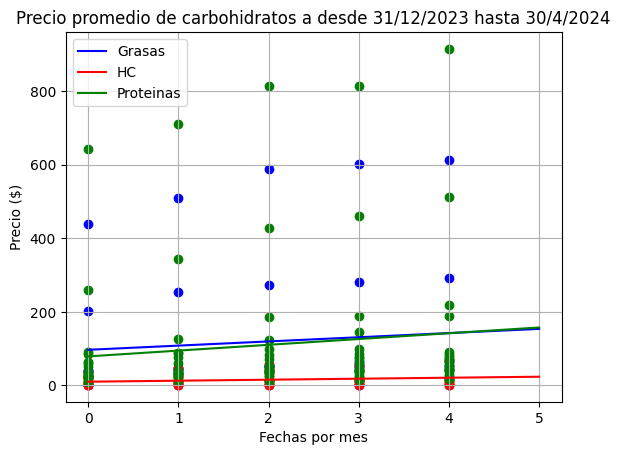

In [31]:
# Recta grasa
X = np.array([1,2,3,4,5])
Y = np.array(PreciosGramoDeGrasa)

x = cuadradosMinimos(X,Y)

a = x[0]
b = x[1]

# Generar valores de x para la recta
r = np.linspace(0,5,100)
y_line = a * r + b

# Graficar la recta y = ax + b
plt.plot(r, y_line, color='blue', label='Grasas')

# Definir el conjunto de puntos y graficarlos
for i in range(len(Y[0])):
    points_x = np.array([0, 1, 2, 3, 4])
    points_y = np.array([Y[0,i],Y[1,i],Y[2,i],Y[3,i],Y[4,i]])
    plt.scatter(points_x, points_y, color='blue')

# Recta HC
X = np.array([1,2,3,4,5])
Y = np.array(PreciosGramoDeHC)

x = cuadradosMinimos(X,Y)

a = x[0]
b = x[1]

# Generar valores de x para la recta
r = np.linspace(0,5,100)
y_line = a * r + b

# Graficar la recta y = ax + b
plt.plot(r, y_line, color='red', label='HC')

# Definir el conjunto de puntos y graficarlos
for i in range(len(Y[0])):
    points_x = np.array([0, 1, 2, 3, 4])
    points_y = np.array([Y[0,i],Y[1,i],Y[2,i],Y[3,i],Y[4,i]])
    plt.scatter(points_x, points_y, color='red')

# Recta proteinas
X = np.array([1,2,3,4,5])
Y = np.array(PreciosGramoDeProteina)

x = cuadradosMinimos(X,Y)

a = x[0]
b = x[1]

# Generar valores de x para la recta
r = np.linspace(0,5,100)
y_line = a * r + b

# Graficar la recta y = ax + b
plt.plot(r, y_line, color='green', label='Proteinas')

# Definir el conjunto de puntos y graficarlos
for i in range(len(Y[0])):
    points_x = np.array([0, 1, 2, 3, 4])
    points_y = np.array([Y[0,i],Y[1,i],Y[2,i],Y[3,i],Y[4,i]])
    plt.scatter(points_x, points_y, color='green')

# Añadir etiquetas y título
plt.xlabel('Fechas por mes')
plt.ylabel('Precio ($)')
plt.title('Precio promedio de carbohidratos a desde 31/12/2023 hasta 30/4/2024')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

## Consigna 6 - Comparar el aumento de la carne en comparación con los otros rubros.

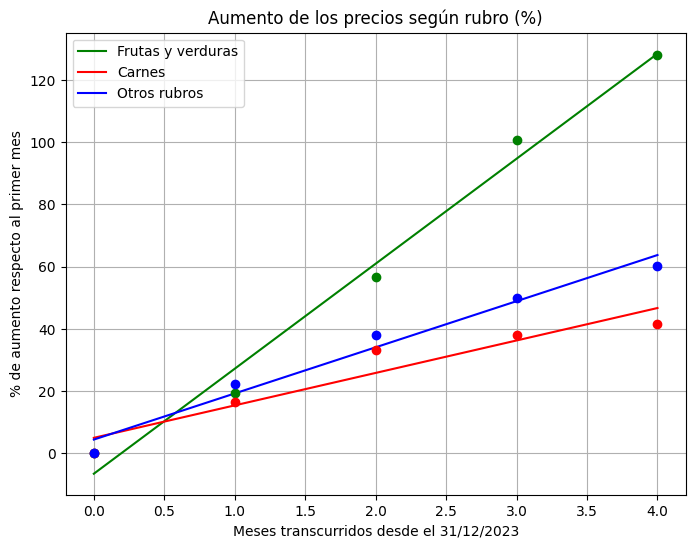

In [ ]:
# Modifico la tabla para que me muestre los nutrientes por gramo

cantidades = consumidores_libres[consumidores_libres.columns[1]]
cLibres = consumidores_libres.copy()
for i in range(cLibres.shape[0]):
    cLibres.iloc[i,1:] = cLibres.iloc[i,1:]/cantidades[i]

# Modifico la tabla para que me muestra el porcentaje de aumento en cada mes según el primer mes

precios = cLibres[cLibres.columns[2]]

for i in range(cLibres.shape[0]):
    for j in range(3,7):
        cLibres.iloc[i,j] = (cLibres.iloc[i,j]/precios[i])*100 - 100
    cLibres.iloc[i,2] = 0

# Reparto el dataframe en rubros y saco un promedio de el aumento de precios según cada mes

frutas_verduras_cl = cLibres[8:17]
carnes_cl = cLibres[17:21]
otroRubros_cl = cLibres[0:8]

frutas_verduras_promedios = []
for i in range(2,7):
    frutas_verduras_promedios.append(frutas_verduras_cl.iloc[:,i].mean())

carnes_promedios = []
for i in range(2,7):
    carnes_promedios.append(carnes_cl.iloc[:,i].mean())

otrosRubros_promedios = []
for i in range(2,7):
    otrosRubros_promedios.append(otroRubros_cl.iloc[:,i].mean())


X = np.array([[1,0],[1,1],[1,2],[1,3],[1,4]])

recta_FV = minimosCuadrados(X,frutas_verduras_promedios)
recta_carnes = minimosCuadrados(X,carnes_promedios)
recta_otrosRubros  = minimosCuadrados(X, otrosRubros_promedios)

a_FV = recta_FV[0]
b_FV = recta_FV[1]

a_Carnes = recta_carnes[0]
b_Carnes = recta_carnes[1]

a_otrosRubros = recta_otrosRubros[0]
b_otrosRubros = recta_otrosRubros[1]

r = np.linspace(0, 4, 100)
y_FV = a_FV + b_FV * r
y_Carnes = a_Carnes + b_Carnes * r
y_otrosRubros = a_otrosRubros + b_otrosRubros * r

# Definir el conjunto de puntos
puntos_x = np.array([0, 1, 2, 3, 4])

plt.figure(figsize=(8, 6))

plt.plot(r, y_FV, color='green', label = "Frutas y verduras")
plt.plot(r, y_Carnes, color='red', label = "Carnes")
plt.plot(r, y_otrosRubros, color='blue', label = "Otros rubros")

# Graficar los puntos
plt.scatter(puntos_x, frutas_verduras_promedios, color='green', zorder=5)
plt.scatter(puntos_x, carnes_promedios, color='red', zorder=5)
plt.scatter(puntos_x, otrosRubros_promedios, color='blue', zorder=5)

plt.xlabel('Meses transcurridos desde el 31/12/2023')
plt.ylabel('% de aumento respecto al primer mes')
plt.title('Aumento de los precios según rubro (%)')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

Se puede apreciar que la carne aumentó en más del 40%, estoy es, sin embargo, menos de lo que aumentan otros rubros, como por ejemplo las frutas y verduras que aumentan más del 120%.
Si quitáramos el 40% del consumo de carne a nuestra dieta (a la canasta básica) esta claramente no cumpliría los márgenes establecidos por la OMS, ya que sabemos que la canasta básica no los cumple.

## Consigna 7 -Proponer dos alimentos de la tabla 3 que lleguen a reemplazar la disminución del 18.5 % de la carne.

In [ ]:
# Calculo el déficit de nutrientes al quitar un 18.8% de consumo de carne

# Estas son las carnes que aparecen en la canasta básica
carnes = ["Bola de Lomo","pollo","Paleta","Hueso c/carne","Carne picada","Higado","pescado","Asado","Mortadela",
          "Paleta cocida"]

# Separo las carnes en un dataframe diferente
tn_carnes = tn[tn["Alimento"].isin(carnes)]

# Creo un dataframe copia del anterior y a este le resto un 18.5% a todas las entradas (nutrientes)
tn_carnes_menos = tn_carnes.copy()
for i in range(tn_carnes.shape[0]):
    for j in range(1,tn_carnes.shape[1]):
        tn_carnes_menos.iloc[i,j] = tn_carnes.iloc[i,j] - (tn_carnes.iloc[i,j]/100)*18.5

# Defino el déficit
tn_deficit = tn_carnes.iloc[:,1:].sum(axis=0) - tn_carnes_menos.iloc[:,1:].sum(axis=0)

# Calculo el precio por gramo de los alimentos en la tabla de consumidores libres
precios_gramo = consumidores_libres.copy()
for i in range(precios_gramo.shape[0]):
    cant = precios_gramo.iloc[i,1]
    for j in range(1,precios_gramo.shape[1]):
        precios_gramo.iloc[i,j] = precios_gramo.iloc[i,j] / cant


# Buscamos los precios de las carnes únicamente
carnes = ['BOLA DE LOMO','PALETA','ASADO','CARNE PICADA COMUN']
dfcarnes = consumidores_libres.loc[consumidores_libres['PRODUCTOS'].isin(carnes)]

# Calculamos el aumento en promedio de la carne por kilo
aumento = []
for i in range(dfcarnes.shape[0]):   #Calculamos los aumentos individuales para luego promediar
    aumento.append(dfcarnes.iloc[i,6])

promedio_aumento = sum(aumento) / dfcarnes.shape[0]  #Promedio del aumento por kilo
promedio_aumento = promedio_aumento / 1000 #Promedio del aumento por gramo

#La carne en promedio aumentó $2.2 por gramo

print("18.5% del consumo diario de carne equivale a:",'\n', tn_deficit)
print("En promedio, la carne por gramo aumentó a:", promedio_aumento)
print("Busco 2 alimentos que reemplacen en valor nutricional el 18.5% menos de carne y que cuesten menos que:"
      , (39.22*promedio_aumento)/2)

18.5% del consumo diario de carne equivale a: 
 Cantidad (gr/ml)        39.220000
HC (gr)                  0.120250
Proteinas (gr)           7.862500
Grasas (gr)              2.954450
Na (gr)                  0.032484
Ca (gr)                  0.004903
Fe (gr)                  0.000975
Azucares Libres (gr)     0.000000
AGS (gr)                 1.809300
AGNI (gr)                2.063305
AG p (gr)                0.399045
Fibra (gr)               0.000000
dtype: float64
En promedio, la carne por gramo aumentó a: 7.45
Busco 2 alimentos que reemplacen en valor nutricional el 18.5% menos de carne y que cuesten menos que: 146.0945


Podemos ver que se pierden en especial proteínas y grasas al disminuir el consumo de carne. Por esto, y al examinar los precios, decidimos que los alimentos más indicados para suplir a la carne serían la harina de trigo y el aceite de girasol.

Por ejemplo, consumir 77 gramos de harina de trigo y 1 gramo de aceite de girasol equivale a consumir los siguientes nutrientes:

In [ ]:
harinaAceitePre = precios_gramo[precios_gramo["PRODUCTOS"].isin(["HARINA DE TRIGO","ACEITE COCINERO GIRASOL"])]
precios = harinaAceitePre[["PRODUCTOS","30/4/2024"]]

harinaAceiteNut = cl[cl["Alimento"].isin(["Harina trigo","Aceite girasol"])]

for j in range(1,harinaAceiteNut.shape[1]):
    harinaAceiteNut.iloc[0,j] = harinaAceiteNut.iloc[0,j]*77
    
for j in range(1,harinaAceiteNut.shape[1]):
    harinaAceiteNut.iloc[1,j] = harinaAceiteNut.iloc[1,j]

print("Precio de los alimentos elegidos :",precios.iloc[1,1]*77+precios.iloc[0,1])
harinaAceiteNut.iloc[:,1:].sum(axis=0)

Precio de los alimentos elegidos : 132.59666666666666


Cantidad (gr/ml)        78.000000
HC (gr)                 52.907556
Proteinas (gr)           7.922444
Grasas (gr)              3.070444
Na (gr)                  0.007700
Ca (gr)                  0.008470
Fe (gr)                  0.001164
Azucares Libres (gr)     0.000000
AGS (gr)                 0.434229
AGNI (gr)                0.418222
AG p (gr)                1.489725
Fibra (gr)               2.464000
dtype: float64

Estos alimentos compensan los nutrientes perdidos que deja consumir 18.5% menos de carne, sin embargo, se podría objetar que se aumenta mucho el consumo de carbohidratos.

## Consigna 8 - Proponer dos alimentos de la tabla 1 que reemplacen la cantidad de proteína perdida.

In [ ]:
tn0.sort_values("Proteinas (gr)", ascending=False)

,Alimento,Cantidad (gr/ml),HC (gr),Proteinas (gr),Grasas (gr),Na (gr),Ca (gr),Fe (gr),Azucares Libres (gr),AGS (gr),AGNI (gr),AG p (gr),Fibra (gr)
5,Queso rallar,1.0,0.036145,0.331325,0.271084,0.012301,0.009506,0.000000e+00,0.000000,0.216867,0.066265,0.004819,0.000000
1,Leche entera en polvo,1.0,0.410000,0.258182,0.248182,0.004040,0.009000,5.454545e-06,0.000000,0.147273,0.070000,0.005455,0.000000
11,Bola de Lomo,1.0,0.000000,0.212059,0.014118,0.000630,0.000030,3.470588e-05,0.000000,0.058529,0.064706,0.003824,0.000000
4,Queso cuartirolo,1.0,0.016393,0.210383,0.218579,0.005694,0.004519,0.000000e+00,0.000000,0.207650,0.057377,0.005464,0.000000
13,pollo,1.0,0.000000,0.210000,0.037937,0.000730,0.000120,1.555556e-05,0.000000,0.029683,0.043175,0.022698,0.000000
9,Hueso c/carne,1.0,0.000000,0.200000,0.100000,0.000660,0.000120,2.266667e-05,0.000000,0.058667,0.065333,0.003733,0.000000
10,Carne picada,1.0,0.000000,0.200000,0.100000,0.000660,0.000120,2.222222e-05,0.000000,0.058519,0.065556,0.003704,0.000000
8,Paleta,1.0,0.000000,0.200000,0.100000,0.000660,0.000120,2.266667e-05,0.000000,0.058667,0.065333,0.003733,0.000000
12,Higado,1.0,0.060000,0.196667,0.032222,0.000860,0.000040,9.888889e-05,0.000000,0.012222,0.004778,0.004667,0.000000
14,pescado,1.0,0.000000,0.194545,0.061818,0.000535,0.000435,1.090909e-05,0.000000,0.015455,0.015455,0.018182,0.000000
